# MTRotator Torque Calibration
2022.04.19 - BQuint

At this date, the values of the torques of the motor from MT Rotator published in the EFD seems unrealistic. 
We want to run a test to confirm the units of the torques and we want to evaluate how many percent of the maximum load is being used at the moment.

In [1]:
from lsst.ts import utils

# Extract your name from the Jupyter Hub
__executed_by__ = os.environ["JUPYTERHUB_USER"]  

# Extract execution date
__executed_on__ = utils.astropy_time_from_tai_unix(utils.current_tai())
__executed_on__.format = "isot"

# This is used later to define where Butler stores the images
summit = os.environ["LSST_DDS_PARTITION_PREFIX"] == "summit"

print(f"\nExecuted by {__executed_by__} on {__executed_on__}."
      f"\n  At the summit? {summit}")


Executed by b1quint on 2022-05-06T15:17:21.405.
  At the summit? True


# Start-up

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

/tmp/ipykernel_11630/1665379685.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) get_node. (Please use lsst.rsp.get_node())
  nb.utils.get_node()


'yagan04'

In [4]:
%matplotlib inline
import os
import sys
import asyncio
import logging

import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import os
import pandas as pd

from astropy.time import Time
from datetime import datetime
from scipy.signal import argrelextrema

from lsst.ts import salobj
from lsst.ts.observatory.control.maintel.mtcs import MTCS

In [5]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [6]:
log = logging.getLogger("rotator_torque_cal")
log.level = logging.DEBUG

In [7]:
domain = salobj.Domain()

In [8]:
mtcs = MTCS(domain=domain, log=log)
mtcs.set_rem_loglevel(40)

In [9]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

## Helper Functions

### Retrieve EFD Client

First of all, the notebook will have different behavior if we run at the Summit or at the NCSA TestSand (NTS) (or other simulated environments). This function simply wraps this difference.

In [10]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

### Retrieve Data from EFD

Second, we want to analyse the motors torques at different angles. For that, we can either use the Binary Logs generated by the MTRotator EUI or we can get the data directly from the EFD, which is much easier. The following function retrieves the data from the EFD.

In [11]:
async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motor1 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque0', 
        start=start, 
        end=end)

    _df_motor2 = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields='torque1', 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motor1, left_index=True, right_index=True)
    _df = pd.merge(_df, _df_motor2, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

### Plot Rotator Angle And Torques

In [12]:
def plot_rotator_angle_and_torques(_df, filename=None):
    """
    Every time that we have the Rotator stopped at a given angle, we have that 
    :math:`\tau_{M1} + \tau_{M2} + \tau_{CM} = 0`. If the center of mass is at 
    the center of the rotation, :math:`\tau_{CM} = 0`, meaning that 
    :math:`\tau_{M1} = - \tau_{M2}`. 
    
    This plot should be used to identify if and when :math:`\tau_{CM} = 0`.
    
    The left y-axis shows the motor torques in N.m while the right y-axis shows 
    the rotator angle in degrees. 
    
    Parameters
    ----------
    _df : DataFrame
    filename : str
    """
    _df = _df.copy()
    _df["torque_sum"] = _df["torque0"] + _df["torque1"]
    
    fig, ax = plt.subplots(
        figsize=(12,6), 
        num=f'Torques and Rotator Position Angle - {filename}')

    ax.plot(_df.index, 
            _df['torque0'].rolling(50).mean(), c="C0",
            label='Actual Torque Axis 1')
    
    ax.fill_between(_df.index, 
            _df['torque0'].rolling(50).min(), 
            _df['torque0'].rolling(50).max(),
            fc="C0", alpha=0.25)

    ax.plot(_df.index, 
            _df['torque1'].rolling(50).mean(), c="C1",
            label='Actual Torque Axis 2')
    
    ax.fill_between(_df.index, 
            _df['torque1'].rolling(50).min(), 
            _df['torque1'].rolling(50).max(),
            fc="C1", alpha=0.25)
    
    ax.plot(_df.index, 
            _df['torque_sum'].rolling(50).mean(), c="C2",
            label='Actual Torque Axis 2')
    
    ax.fill_between(_df.index, 
            _df['torque_sum'].rolling(50).min(), 
            _df['torque_sum'].rolling(50).max(),
            fc="C2", alpha=0.25)
    
    ax.set_ylabel('Actual Torque Axis [N.m]')
    ax.set_ylim(-6e-4, 6e-4)
    ax.set_xlabel('Time [UTC]')
    ax.grid(lw=0.5, alpha=0.2)
    ax.ticklabel_format(axis="y", style="sci")
    ax.fmt_xdata = mdates.DateFormatter("%H:%M:S")

    ax2 = ax.twinx()
    ax2.plot(_df.index, _df["torque1"] * 0, 'k', alpha=0.1)
    ax2.fill_between(
        _df.index, 0, _df["actualPosition"], alpha=0.1, 
        fc='k', label='Rotator Position Angle')
    ax2.fmt_xdata = mdates.DateFormatter("%H:%M:S")

    ax2.set_ylabel('Rotator Position Angle [deg]')

    fig.autofmt_xdate()
    fig.legend(loc='lower center', ncol=4, )
    fig.suptitle(f"Torques and Rotator Position Angle\n"
                 f"{_df.index[0].strftime('%Y-%m-%d %H:%M:%S')}")
    
    if filename:
        os.makedirs('plots', exist_ok=True)
        fig.savefig(os.path.join('plots', filename), facecolor='white', dpi=150)
        print(f"Plot file saved to plots/{filename}")
        
    plt.show()

### Plot Torques Vs Rotator Angle

Some people prefer this kind of data visualization. So let's leave it here to complement the data analyzis.

In [13]:
def plot_torque_vs_rotator_angle(_df, filename=None):
    """
    Plots the motor torques vs the rotation angle, showing a cyclic plot.
    
    Parameters
    ----------
    _df : DataFrame
    filename : str
    """
    fig, ax = plt.subplots(
        figsize=(12,12),
        num=f"Torque Vs Rotator Angle - {filename}",)
        
    _df = _df.copy()
    _df["torque_sum"] = _df["torque0"] + _df["torque1"]
    
    ax.plot(_df["actualPosition"], _df["torque0"], 
            label="Motor 1")
    ax.plot(_df["actualPosition"], _df["torque1"], 
            label="Motor 2")
    ax.plot(_df["actualPosition"], _df["torque_sum"], 
            label="Sum")
    
    ax.set_xlabel('Rotator Angle [deg]')
    ax.set_ylabel('Total Torque [N.m]')
    ax.grid(lw=0.5, alpha=0.2)
    
    fig.legend(loc='lower center', ncol=3, )
    fig.suptitle(f"Torques Vs Rotator Position Angle\n"
                 f"{_df.index[0].strftime('%Y-%m-%d %H:%M:%S')}")
    
    if filename:
        os.makedirs('plots', exist_ok=True)
        fig.savefig(os.path.join('plots', filename), facecolor='white', dpi=150)
        print(f"Plot file saved to plots/{filename}")
        
    plt.show()

### Print Average Torques at given Angle

In [14]:
def get_average_torques_at_angle(_df, angle=0):
    """ 
    Prints out the average torques at a given rotation angle.
    """
    sub_df = _df[_df["actualPosition"].round(1) == angle]
    
    avg_torque_motor1 = sub_df['torque0'].mean()
    std_torque_motor1 = sub_df["torque0"].std()
    
    avg_torque_motor2 = sub_df["torque1"].mean()
    std_torque_motor2 = sub_df["torque1"].std()
    
    avg_total = avg_torque_motor1 + avg_torque_motor2
    std_total = std_torque_motor1 + std_torque_motor2
    sin = np.sin(np.deg2rad(angle))
    
    print(
        f"Average Torques at {angle} deg\n"
        f"Motor 1 = {avg_torque_motor1:.5f} N.m +/- {std_torque_motor1:.5f} N.m\n"
        f"Motor 2 = {avg_torque_motor2:.5f} N.m +/- {std_torque_motor2:.5f} N.m\n"
        f"Total Torque: {avg_total:.5f} N.m +/- {std_total:.5f} N.m\n")

#         f"Total Torque divided by sin(theta): {avg_total / sin:.3f} N.m"
#         f" +/- {std_total / sin:.3f} N.m\n")

### Test Class

In [15]:
class TestClass:
    """
    Wrap the data analysis involved on each of the test runs.  
    The class constructor only requires the time stamps as ISOT stamps in UTC.

    Parameters
    ----------
    start_time :  str
        Initial data analysis time in UTC as ISOT format.
    end_time : str 
        Final data analysis time in UTC as ISOT format.
    """
    def __init__(self, start_time, end_time):
        from astropy.time import Time 
        self.utc_start = Time(start_time, format="isot", scale="utc")
        self.utc_end = Time(end_time, format="isot", scale="utc")
        self.efd_client = None
        self.efd_df = None
    
    async def start(self):
        self.efd_client = retrieve_efd_client(is_at_summit=summit)
        self.efd_df = await retrieve_rotator_angle_and_torques_from_efd(
            self.efd_client, self.utc_start, self.utc_end)

## Test Run - 2022.04.20

We have now `mtmount`, `mtrotator`, and `mthexapod_1` in an ENABLED state.  
Bringing up the system came up smoothly. Now, let's divide our test in a couple of sub-tests.  
Remember that for all the tests, we want to evaluate how much load relative to the maximum we have. 

**Test A**: without any new counterweights, we want to move the rotator +/- 1 deg.  
Since it should be balanced, the total torque should be around 0 N.m.  The total current as well.  

**Test B**: without any new conterweights, we want to run a few big movements.  
Since the ccw following might fail, we will restrict ourselfs to steps of 30 deg to avoid losing time with recovering the system.

**Test C**: without any new conterweights, we want to run a few big movements with the hexapod in an extreme position.
Since the ccw following might fail, we will restrict ourselfs to steps of 30 deg to avoid losing time with recovering the system.

**Test D**: add couterweights to ComCam and move the rotator +/- 1 deg. 
This will give us an idea of the correct units and calibrations.

**Test E**: with the new counterweits, we want to run a few big movements.  
Since the ccw following might fail, we will restrict ourselfs to steps of 30 deg to avoid losing time with recovering the system.

**Test F**: with the new counterweits, we want to run a few big movements with the hexapod in an extreme position.
Since the ccw following might fail, we will restrict ourselfs to steps of 30 deg to avoid losing time with recovering the system.

In [ ]:
index = os.getegid() + np.random.randint(-5, 5)
print(f"Using index {index}")

script = salobj.Controller("Script", index=index)

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test A"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

### Test A
**Remember to log in the EUI**

In [ ]:
# 5 seconds sleep is the minimal time required for the loop to work
print(f"Loop Start - Moving to 0 deg")
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)
await asyncio.sleep(5)  

for i in range(10):
    print(f"Iteration {i} - Moving to -1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=-1, timeout=5)
    await asyncio.sleep(5)
    
    print(f"Iteration {i} - Moving to +1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=+1, timeout=5)
    await asyncio.sleep(5)
    
print(f"Loop Done - Moving back to 0 deg")
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

The Rotator EUI was **not** happy with this test. It simply crashed. The CSC reports:

```
Reader unexpectedly closed.
b'Traceback (most recent call last):\n File "/opt/lsst/software/stack/miniconda/lib/python3.8/site-packages/lsst/ts/hexrotcomm/command_telemetry_client.py", line 272, in read_loop\n await tcpip.read_into(self.reader, self.header)\n File "/opt/lsst/software/stack/miniconda/lib/python3.8/site-packages/lsst/ts/tcpip/utils.py", line 73, in read_into\n raise ConnectionError()\nConnectionError'
```
Let me recover and try again. I will use 7.5 sleep instead.

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test A"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

In [ ]:
time_sleep = 7.5  # Minimal time required for the loop to work

for i in range(10):
    print(f"Iteration {i} - Moving to -1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=-1, timeout=5)
    await asyncio.sleep(time_sleep)
    
    print(f"Iteration {i} - Moving to +1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=+1, timeout=5)
    await asyncio.sleep(time_sleep)
    
print(f"Loop Done - Moving back to 0 deg")
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

I ran this test twice. I created a START/FAIL pair for the first time since I forgot to record the log via EUI.  
The second run is Ok and has a START/END pair.

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

Finally, I ran this test once more (around 16:26 UTC) after Alysha installed a new lap at the top of ComCam. 

---
### Test B

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test B"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

Make sure we start at 0 deg.

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=-88, timeout=5)

Start loop. **Remember to start the log in the EUI!**

In [ ]:
time_sleep = 60  # Minimal time required for the loop to work

# positions = np.concatenate([np.arange(7) * 15, 
#                             np.arange(6)[::-1] * 15,
#                             np.arange(7)[1:] * -15, 
#                             np.arange(6)[::-1] * -15])

positions = np.arange(6)[::-1] * -15
                      
for pos in positions:

    if np.abs(pos) == 90:
        pos += (-2 * np.sign(pos))        
        
    print(f"Moving to {pos}deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=pos, timeout=5)
    await asyncio.sleep(time_sleep)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

    - 15:10 - FAIL - Steps of 30 deg
    - 16:33 - FAIL - Steps of 30 deg
    - 16:39 - FAIL - SMlink Fault
    - 16:48 - FAIL - 
    - 16:56 - END - We did not complete the loop because the was a following error. However, considering time contrainsts, I will move forward.
    - 17:32 - END - just collected the last ramp up back to 0.

### Test C

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test C"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

In [ ]:
await mtcs.rem.mthexapod_1.cmd_move.set_start(x=0, y=0, z=0, u=0.36, v=0, w=0, sync=True)

In [ ]:
await mtcs.rem.mthexapod_1.cmd_move.set_start(x=-11000, y=0, z=0, u=0.36, v=0, w=0, sync=True)

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=88, timeout=5)

In [ ]:
time_sleep = 45  # Minimal time required for the loop to work

positions = np.concatenate([
    # np.arange(7) * 15, 
    np.arange(6)[::-1] * 15,
    np.arange(7)[1:] * -15, 
    np.arange(6)[::-1] * -15]
)

for pos in positions:

    if np.abs(pos) == 90:
        pos += (-2 * np.sign(pos))        

    print(f"Moving to {pos} deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=pos, timeout=5)
    await asyncio.sleep(time_sleep)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

- FAIL - 17:51 - SMlink fault when moving to 88 deg. Starting over from 88 deg.
- END - 17:57 - Fininshed loop 

### Checkpoint - Add Counterweight

We are now adding a counterweight to ComCam and evaluating how much that affects the currents and torques reported on the EFD and on the EUI.

The counterweight is approximately at 80 cm (ComCam Radius) minus 13 cm (outer limit to the position of the base of the counterweight plate) which gives us approximately 67 cm.

In [ ]:
143 - from cweight to cwieght

In [ ]:
(160 - 23)/2

In [ ]:
102 lb = 46.2664 Kg

In [ ]:
(46.2 * 9.98) * 68

---
### Test D

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test D"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

In [ ]:
# 5 seconds sleep is the minimal time required for the loop to work
print(f"Loop Start - Moving to 0 deg")
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)
await asyncio.sleep(7.5)  

for i in range(10):
    print(f"Iteration {i} - Moving to -1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=-1, timeout=5)
    await asyncio.sleep(7.5)
    
    print(f"Iteration {i} - Moving to +1deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=+1, timeout=5)
    await asyncio.sleep(7.5)
    
print(f"Loop Done - Moving back to 0 deg")
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

### Test E

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test E"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

Make sure we start at 0 deg.

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=-88, timeout=5)

Start loop. **Remember to start the log in the EUI!**

In [ ]:
time_sleep = 45  # Minimal time required for the loop to work

positions = np.concatenate([
    # np.arange(7) * 15, 
    # np.arange(6)[::-1] * 15,
    # np.arange(7)[1:] * -15, 
    np.arange(6)[::-1] * -15]
)
                      
for pos in positions:

    if np.abs(pos) == 90:
        pos += (-2 * np.sign(pos))        
        
    print(f"Moving to {pos}deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=pos, timeout=5)
    await asyncio.sleep(time_sleep)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

    - 19:10 - FAIL - SMlink Fault - failed when coming um from -88 deg
    - 19:30 - END  - Starting from -88 deg

### Test F

In [ ]:
now = datetime.now()
test_message = "Rotator Torque Calibrations Test F"
script.log.info(f"START -- {test_message} -- Starting Time: {now} UTC")

In [ ]:
await mtcs.rem.mthexapod_1.cmd_move.set_start(x=0, y=0, z=0, u=0, v=0, w=0, sync=True)

In [ ]:
await mtcs.rem.mthexapod_1.cmd_move.set_start(x=-11000, y=0, z=0, u=0.36, v=0, w=0, sync=True)

In [ ]:
await mtcs.rem.mtrotator.cmd_move.set_start(position=0, timeout=5)

In [ ]:
time_sleep = 30  # Minimal time required for the loop to work

positions = np.concatenate([
    # np.arange(7) * 15, 
    # np.arange(6)[::-1] * 15,
    np.arange(7)[1:] * -15, 
    np.arange(6)[::-1] * -15
])

for pos in positions:

    if np.abs(pos) == 90:
        pos += (-2 * np.sign(pos))        

    print(f"Moving to {pos} deg")
    await mtcs.rem.mtrotator.cmd_move.set_start(position=pos, timeout=5)
    await asyncio.sleep(time_sleep)

In [ ]:
script.log.info(f"END -- {test_message} -- Starting Time: {now} UTC")

## EFD Data Analysis

### Test A

In [17]:
test_a = TestClass("2022-04-20T16:27:00", "2022-04-20T16:33:00")
await test_a.start()

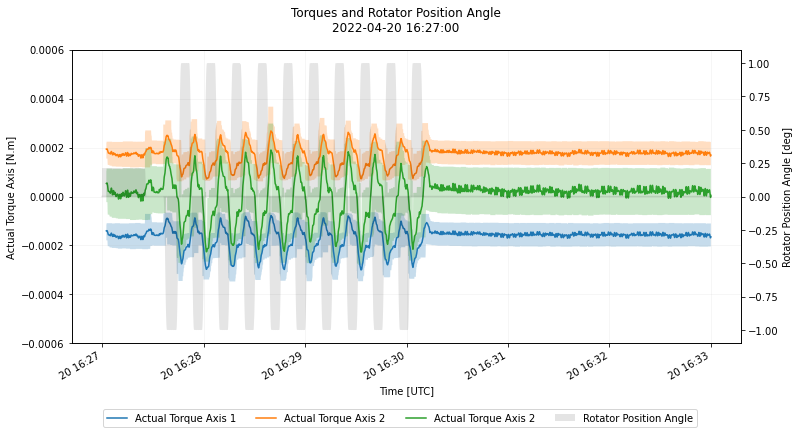

In [18]:
plot_rotator_angle_and_torques(test_a.efd_df)

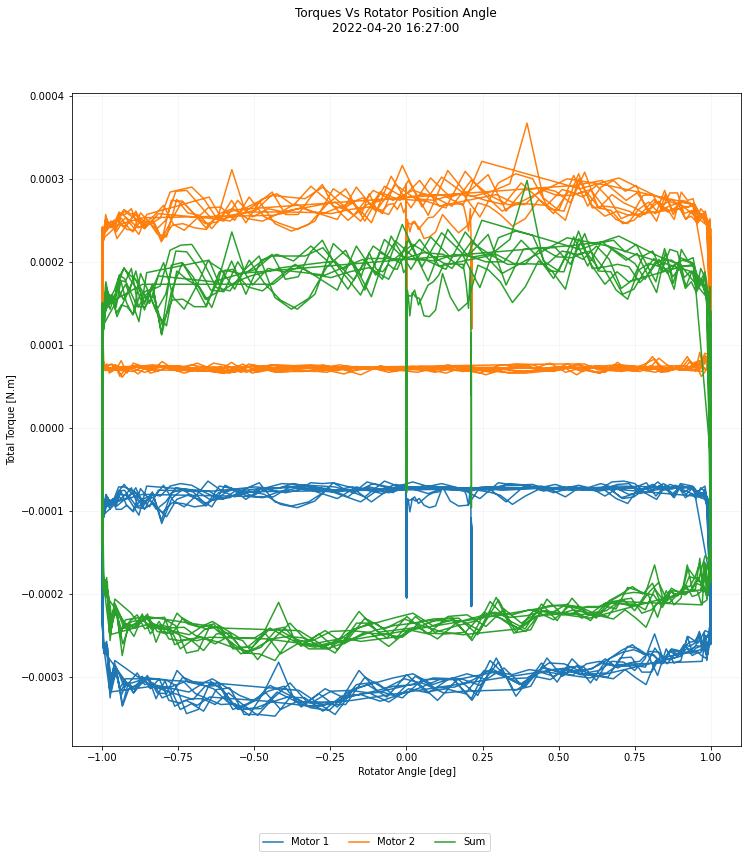

In [19]:
plot_torque_vs_rotator_angle(test_a.efd_df)

In [20]:
get_average_torques_at_angle(test_a.efd_df, angle=0)

Average Torques at 0 deg
Motor 1 = -0.00015 N.m +/- 0.00004 N.m
Motor 2 = 0.00018 N.m +/- 0.00004 N.m
Total Torque: 0.00002 N.m +/- 0.00007 N.m



One of the first thing we want to do is to compare these values with the ones exported from the Rotator EUI. 

### Test B

In [21]:
test_b = TestClass("2022-04-20T16:56:00", "2022-04-20T17:42:00")
await test_b.start()

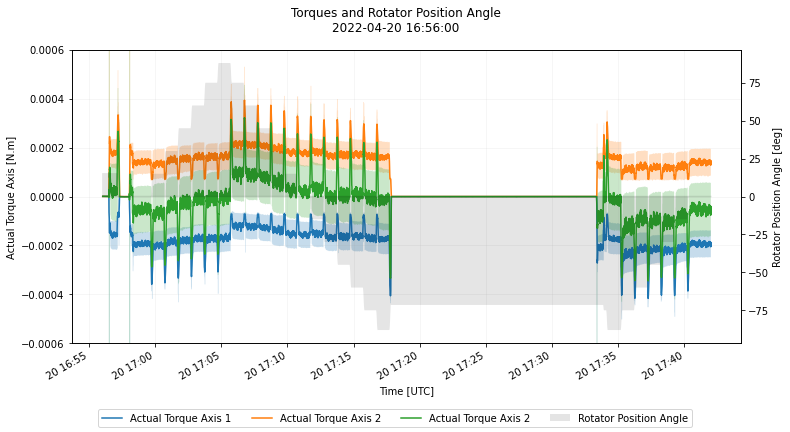

In [22]:
plot_rotator_angle_and_torques(test_b.efd_df)

Plot file saved to plots/foo.png


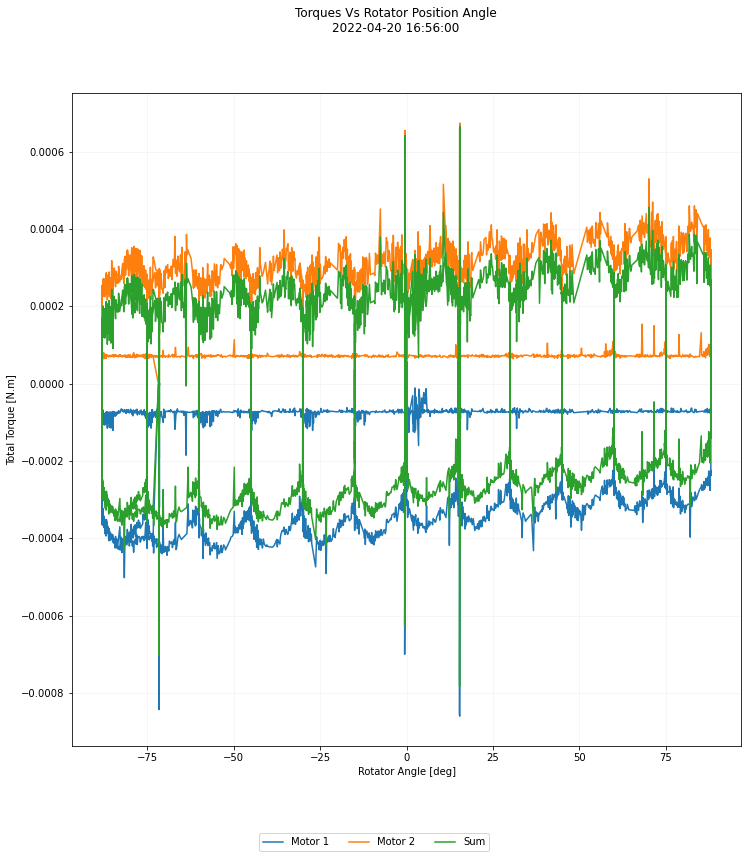

In [23]:
plot_torque_vs_rotator_angle(test_b.efd_df, "foo.png")

### Test C

In [24]:
test_c = TestClass("2022-04-20T17:51:00", "2022-04-20T18:13:00")
await test_c.start()

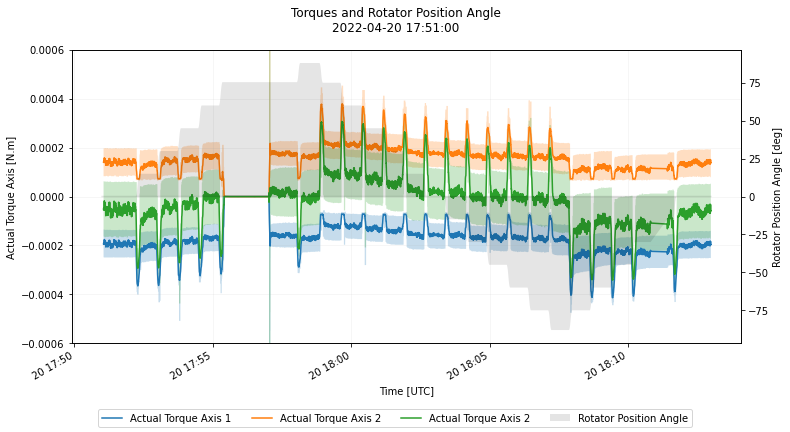

In [25]:
plot_rotator_angle_and_torques(test_c.efd_df)

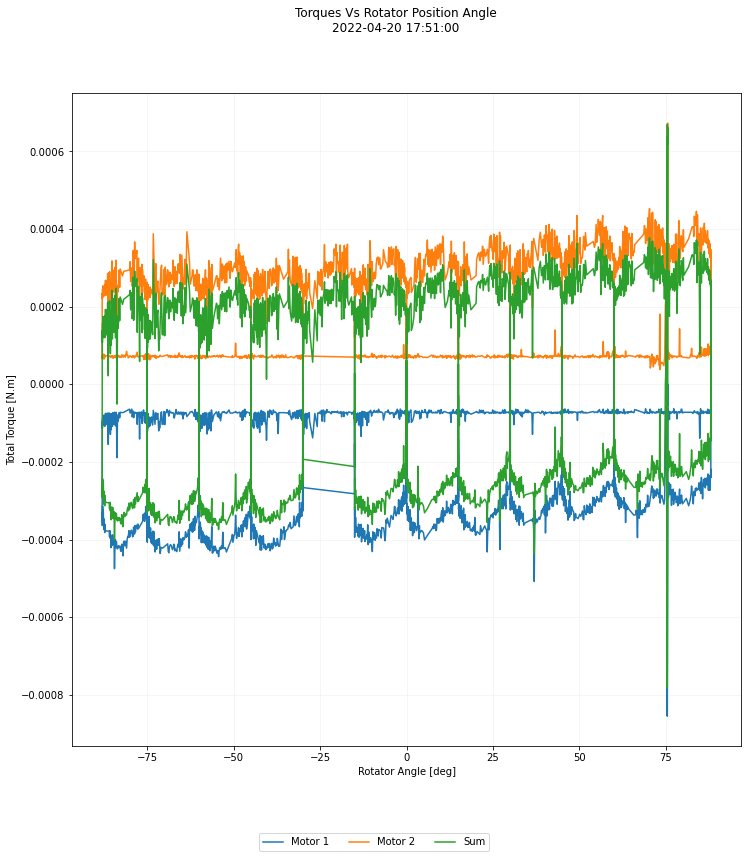

In [26]:
plot_torque_vs_rotator_angle(test_c.efd_df)

### Test D


In [27]:
test_d = TestClass("2022-04-20T19:10:00", "2022-04-20T19:15:00")
await test_d.start()

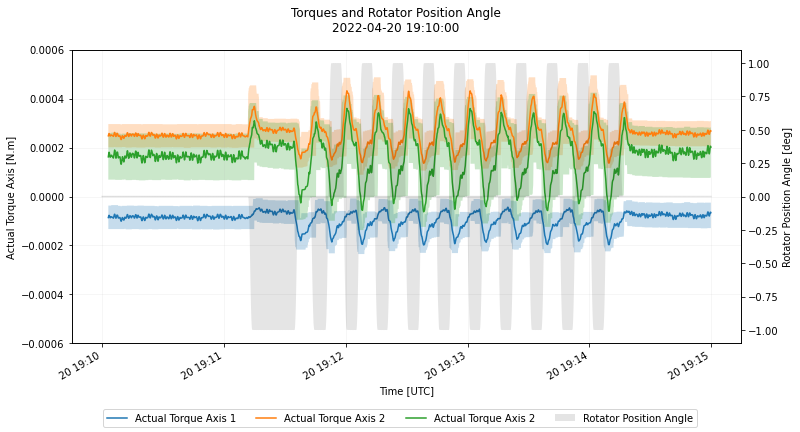

In [28]:
plot_rotator_angle_and_torques(test_d.efd_df)

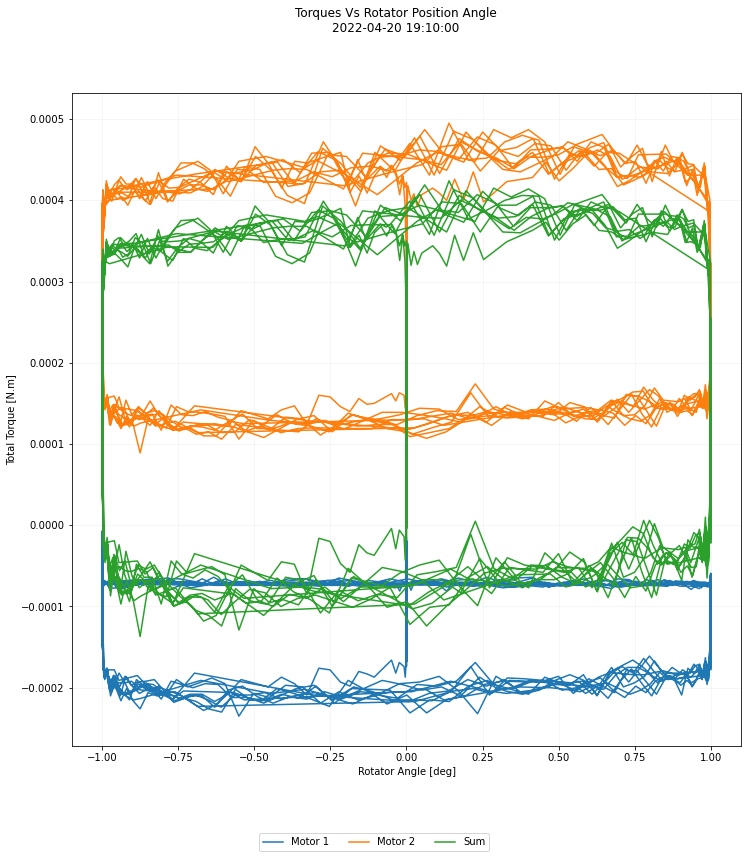

In [29]:
plot_torque_vs_rotator_angle(test_d.efd_df)

### Test E

In [30]:
test_e = TestClass("2022-04-20T19:30:56", "2022-04-20T19:36:00")
await test_e.start()

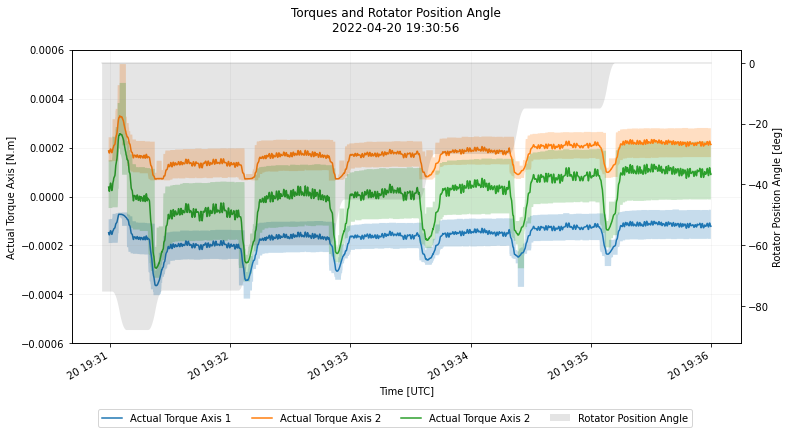

In [31]:
plot_rotator_angle_and_torques(test_e.efd_df)

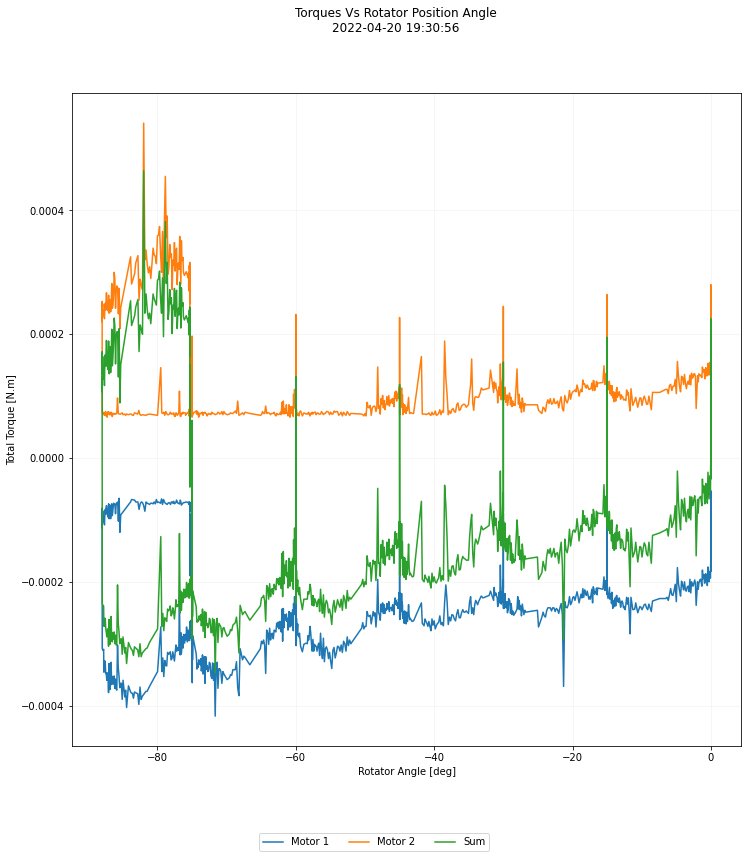

In [32]:
plot_torque_vs_rotator_angle(test_e.efd_df)

### Test F

In [33]:
test_f = TestClass("2022-04-20T19:35:00", "2022-04-20T19:43:00")
await test_f.start()

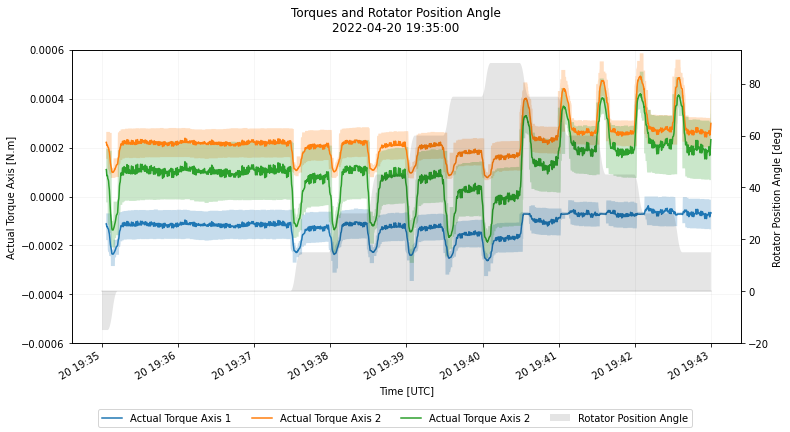

In [34]:
plot_rotator_angle_and_torques(test_f.efd_df)

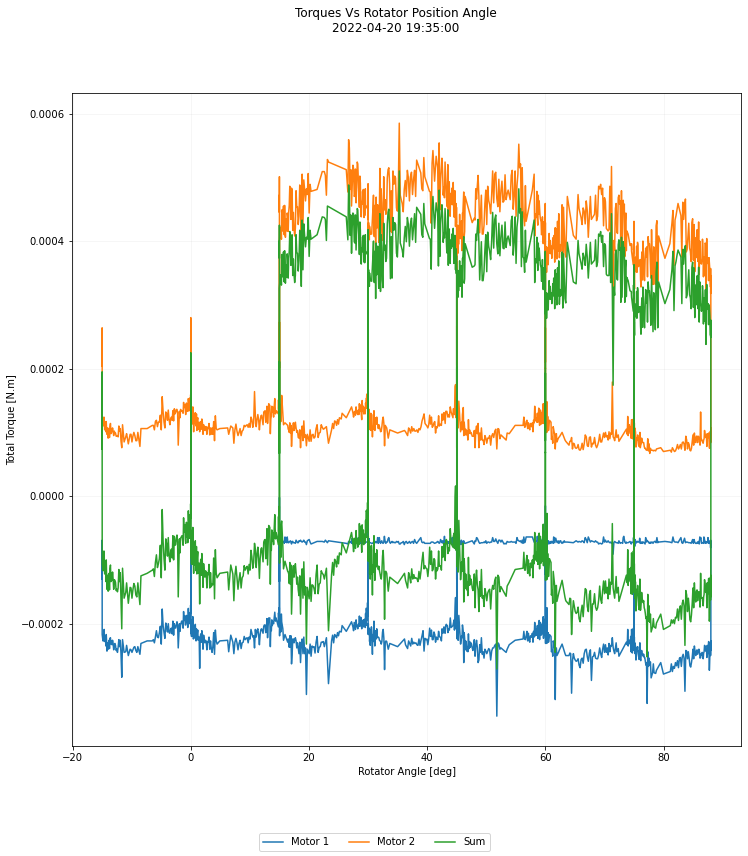

In [35]:
plot_torque_vs_rotator_angle(test_f.efd_df)

## EUI Data Analysis

One of the things I am curious about, it the data published from the EUI.  
The CSV file below contains data recorded during the tests above.  

In [37]:
eui_df = pd.read_csv("2022_04_20.csv")
eui_df = eui_df.set_index("UTC", drop=False)
eui_df = eui_df.sort_index()

eui_df["actualPosition"] = eui_df["Rotator_Position_deg"]
eui_df["torque0"] = eui_df["actual_torque_axis_1"]
eui_df["torque1"] = eui_df["actual_torque_axis_2"]

Since this dataframe contains data collected the whole day, we want to evaluate the total torque near to 0 deg before and after adding the counterweight.  
The following line prints out the torque values before adding the counterweight to ComCam.

In [38]:
get_average_torques_at_angle(eui_df.loc["2022-04-20T16:27:00":"2022-04-20T18:13:00"])

Average Torques at 0 deg
Motor 1 = -174.63539 N.m +/- 41.38194 N.m
Motor 2 = 159.38651 N.m +/- 41.18580 N.m
Total Torque: -15.24888 N.m +/- 82.56774 N.m



Now, from the LabView code in the EUI, the code converts from Torque to Currents (Amp.) using the formula below:

```
Current = Torque x 4.6 Amp / 1200 N.m
```

This means that the current displayed in the EUI should be between `0.6A` and `0.7A`, which is roughtly correct.  
And this also confirm that the values that come directly from the EUI are in N.m.   
Hence, **there is no need for the CSC to publish the torques to the archive with a 1e-6 factor.**

Later on the same day, we added 102 lbs (~ 46.3 Kg) to the negative side of ComCam.  
The distance between the counterweight and the center of rotation was about 68 cm.  
This gives us an extra torque of:

In [39]:
(46.3 * 9.98) * 68e-2

314.21032

About 315 N.m.  
Now, we can check the torque values near 0 deg in this time window.

In [40]:
get_average_torques_at_angle(eui_df.loc["2022-04-20T19:10:00":"2022-04-20T19:43:00"])

Average Torques at 0 deg
Motor 1 = -78.30477 N.m +/- 40.57413 N.m
Motor 2 = 257.12951 N.m +/- 43.58996 N.m
Total Torque: 178.82474 N.m +/- 84.16408 N.m



The total torque applied by the both motors was about 180 N.m, accordingly to the EUI.  
But, most interestingly, the torque that motor 2 was applying to hold the counterweight was about 260 N.m.   
This is a factor of 260 N.m / 315 N.m = 0.82